In [1]:
from imutils import paths
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
from skimage.feature import local_binary_pattern
from skimage import data, exposure

In [2]:
train_dataset_path = "/Users/harysetiawan/Documents/College Project/PCD/FinalProject/dataset/train"
test_dataset_path = "/Users/harysetiawan/Documents/College Project/PCD/FinalProject/dataset/test"

train_dataset_list = list(paths.list_images(train_dataset_path))
test_dataset_list = list(paths.list_images(test_dataset_path))

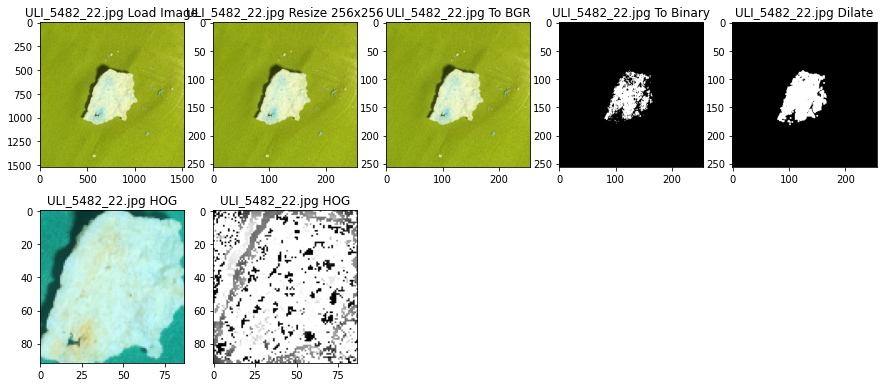

In [3]:
columns = 5
rows = 3
plt.figure(figsize=(15,10))

extracted_shape = []
img_path = train_dataset_list[435]

title = img_path.split("/")[10] 

i = 1

img = cv2.imread(img_path,flags=cv2.IMREAD_COLOR)
plt.subplot(rows, columns, i)
plt.title("{} Load Image".format(title))
plt.imshow(img)

i+=1
resolution = 256
img = cv2.resize(img,(resolution,resolution),interpolation=cv2.INTER_AREA)
plt.subplot(rows, columns, i)
plt.title("{} Resize {}x{}".format(title,resolution,resolution))
plt.imshow(img)

i+=1
img_rgb = cv2.cvtColor(img,code=cv2.COLOR_BGR2RGB)
plt.subplot(rows, columns, i)
plt.title("{} To BGR".format(title))
plt.imshow(img)

i+=1
img = cv2.cvtColor(img_rgb,code=cv2.COLOR_RGB2GRAY)
plt.subplot(rows, columns, i)
plt.title("{} To Gray".format(title))
plt.imshow(img,cmap='gray')


tresh, img = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
plt.subplot(rows, columns, i)
plt.title("{} To Binary".format(title))
plt.imshow(img,cmap='gray')

i+=1
kernal = np.ones((2, 2), np.uint8)
dilation = cv2.dilate(img, kernal, iterations=2)
plt.subplot(rows, columns, i)
plt.title("{} Dilate".format(title))
plt.imshow(dilation,cmap='gray')


i+=1
contours = cv2.findContours(
    dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = contours[0] if len(contours) == 2 else contours[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    ROI = img_rgb[y:y+h, x:x+w]
    break
plt.subplot(rows, columns, i)
plt.title("{} HOG".format(title))
plt.imshow(ROI,cmap='gray')

img = cv2.cvtColor(ROI,cv2.COLOR_RGB2GRAY)

i+=1
# settings for LBP
radius = 7
n_points = 8 * radius
img_lbp = local_binary_pattern(img,n_points, radius, 'uniform')

plt.subplot(rows, columns, i)
plt.title("{} HOG".format(title))
plt.imshow(img_lbp,cmap='gray')


In [4]:
def extract_roi(image_path,resolution = 256):
    img = cv2.imread(image_path,flags=cv2.IMREAD_COLOR)
    img = cv2.resize(img,(resolution,resolution),interpolation=cv2.INTER_AREA)
    img_rgb = cv2.cvtColor(img,code=cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img_rgb,code=cv2.COLOR_RGB2GRAY)
    tresh, img = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
    kernal = np.ones((2, 2), np.uint8)
    dilation = cv2.dilate(img, kernal, iterations=2)
    contours = cv2.findContours(
        dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = contours[0] if len(contours) == 2 else contours[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        ROI = img_rgb[y:y+h, x:x+w]
        break
    ROI = cv2.resize(ROI,(resolution,resolution),interpolation=cv2.INTER_AREA)
    return ROI

(<matplotlib.image.AxesImage at 0x13471b820>, (256, 256, 3), numpy.ndarray)

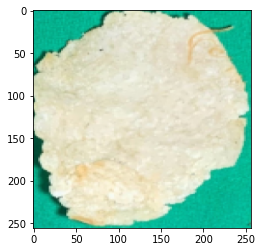

In [5]:
img = extract_roi(image_path="/Users/harysetiawan/Documents/College Project/PCD/FinalProject/Images/train/ULI/ULI_5401.jpg")
plt.imshow(img),img.shape,type(img)

In [6]:
plt.figure(figsize=(15,7))
columns = 5
rows = 3

def extract_feature(image_list):
    extracted_shape = []
    for i,img_path in enumerate(image_list):
        title = img_path.split("/")[10]

        img = extract_roi(image_path=img_path)
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        radius = 7
        n_points = 8 * radius
        img_lbp = local_binary_pattern(img,n_points, radius, 'uniform')
        img_array = img_lbp.reshape((1,img_lbp.shape[0]*img_lbp.shape[1]))[0]

        extracted_shape.append(np.append([title.split("_")[0]],img_array))
        ## Show Image
        # plt.subplot(rows, columns, i+1)
        # plt.axis(False)
        # plt.grid(True)
        # plt.title(title)
        # plt.imshow(hog_image,cmap='gray')
    return extracted_shape

train_dasets = extract_feature(train_dataset_list)
test_dasets = extract_feature(test_dataset_list)


<Figure size 1080x504 with 0 Axes>

In [7]:
train_dasets = pd.DataFrame(train_dasets)
test_dasets = pd.DataFrame(test_dasets)

In [8]:
train_dasets.head(5)

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,65536
0,ULI,8.0,57.0,17.0,18.0,57.0,22.0,24.0,57.0,57.0,...,57.0,0.0,0.0,57.0,57.0,5.0,5.0,9.0,8.0,2.0
1,ULI,15.0,16.0,17.0,18.0,20.0,22.0,24.0,29.0,29.0,...,15.0,15.0,16.0,12.0,11.0,11.0,11.0,12.0,16.0,15.0
2,ULI,15.0,16.0,17.0,18.0,20.0,22.0,24.0,29.0,29.0,...,29.0,29.0,29.0,24.0,22.0,20.0,18.0,17.0,16.0,15.0
3,ULI,7.0,9.0,57.0,57.0,1.0,57.0,57.0,27.0,29.0,...,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0
4,ULI,8.0,9.0,11.0,18.0,20.0,57.0,57.0,57.0,57.0,...,57.0,57.0,29.0,24.0,57.0,0.0,0.0,57.0,16.0,13.0


In [9]:
test_dasets.head(5)

,0,1,2,3,4,5,6,7,8,9,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,65536
0,ULI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,...,57.0,57.0,57.0,57.0,15.0,20.0,18.0,17.0,16.0,15.0
1,ULI,8.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,57.0,...,20.0,22.0,25.0,24.0,22.0,20.0,7.0,3.0,2.0,0.0
2,ULI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,29.0,...,57.0,15.0,15.0,10.0,9.0,9.0,8.0,8.0,9.0,10.0
3,ULI,57.0,57.0,57.0,15.0,16.0,57.0,0.0,0.0,57.0,...,57.0,57.0,0.0,0.0,1.0,0.0,0.0,17.0,16.0,57.0
4,ULI,3.0,7.0,8.0,57.0,20.0,22.0,24.0,4.0,4.0,...,57.0,57.0,57.0,18.0,17.0,16.0,14.0,13.0,11.0,57.0


In [10]:
train_dasets.to_csv("train_dasets.csv",index=False)
test_dasets.to_csv("test_dasets.csv",index=False)